# Logistic Regression

**Author:** &nbsp; Yiming Zhao

**Submission Data:** &nbsp; 9/30/2025

**Purpose:**

This notebook is a practice about Logistic Regression, Feature Transformation and Model Evaluation.

**Key Words:** &nbsp; Logistic Regression, Polynomial Transformation, Spline Transformation, Cross Validation, ROC

## Dataset: Heart Failure Prediction Dataset

**Description:**

This dataset has 11 clinical features for predicting heart disease events.

**Features:**

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

**Citation:**

fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved]

from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

In [ ]:
# Load the dataset and take a glance
dataset = pd.read_csv("heart.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Summary:

There is not missing data.

Next step:

Use data visualization to check target value as well as the relationship between features and target value.

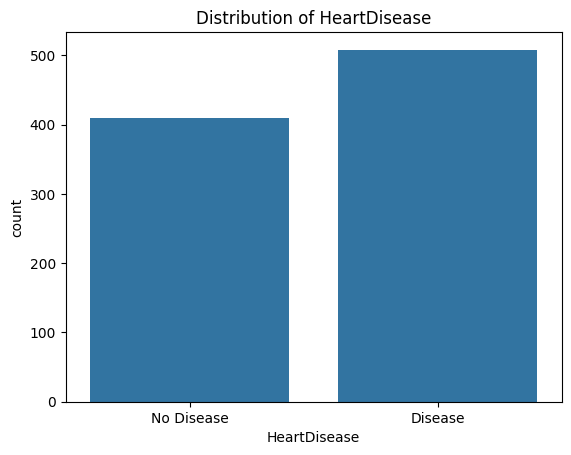

In [ ]:
sns.countplot(x='HeartDisease', data=dataset)
plt.title('Distribution of HeartDisease')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.show()

Summary:

The target variable is quite balanced.

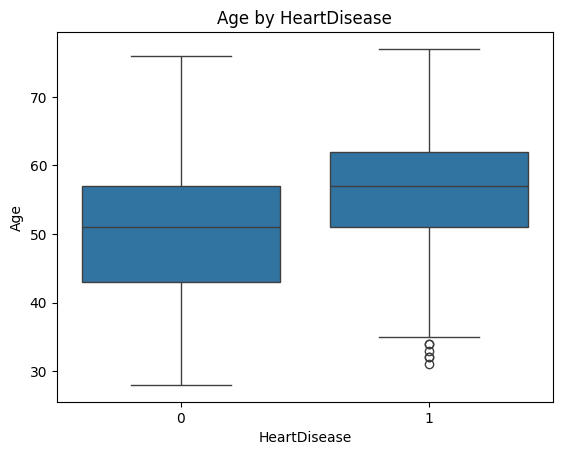

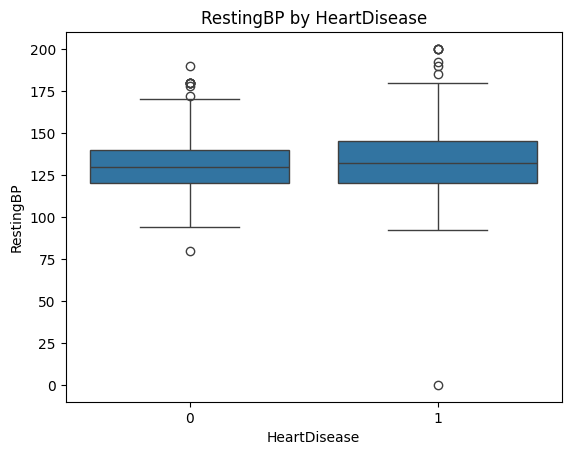

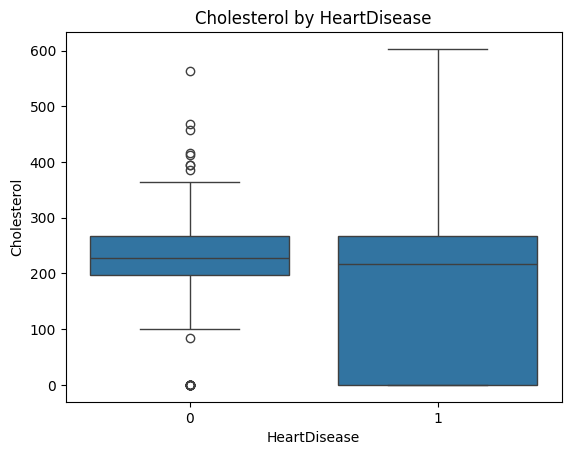

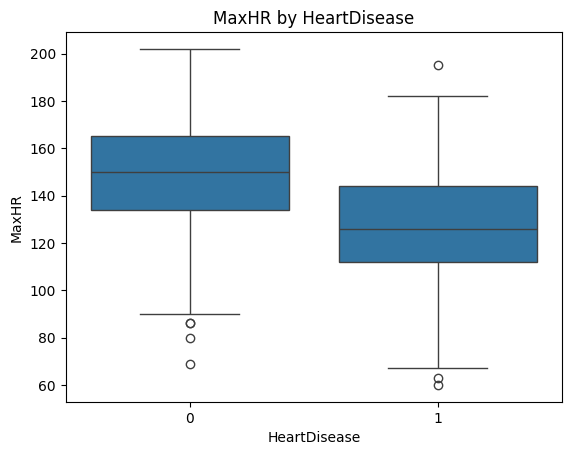

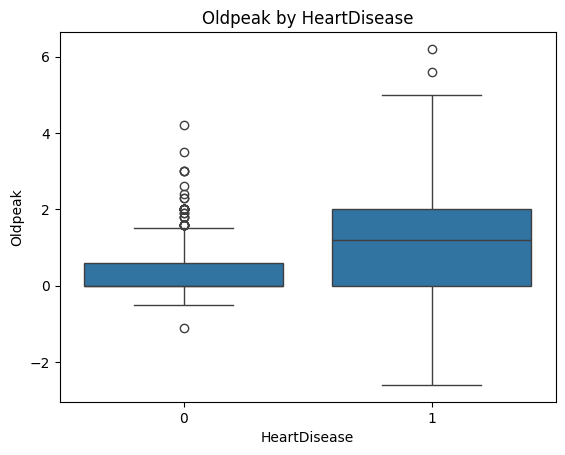

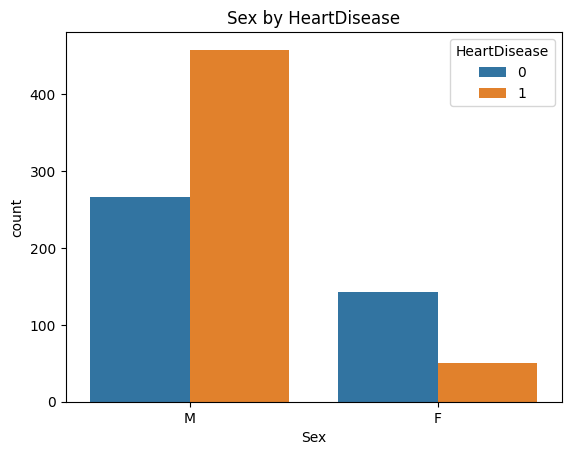

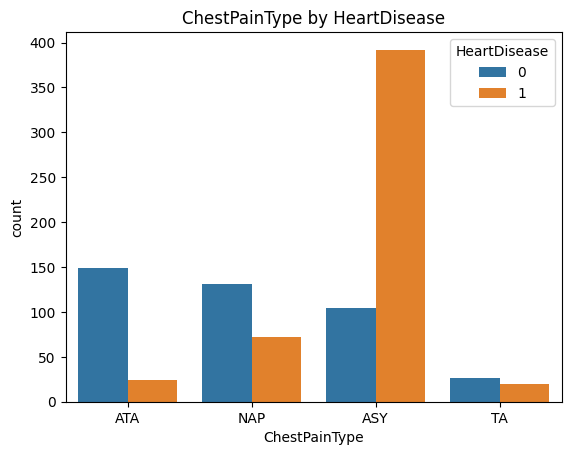

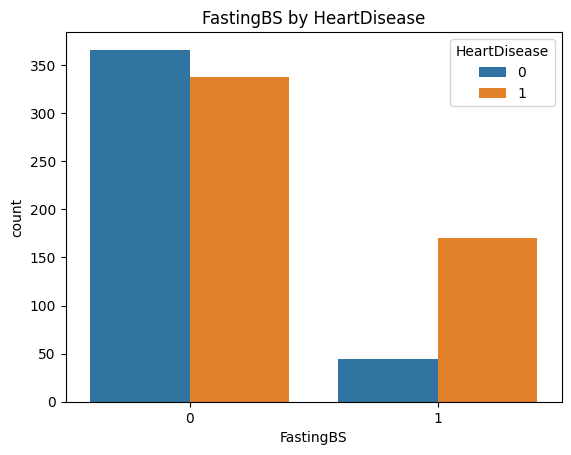

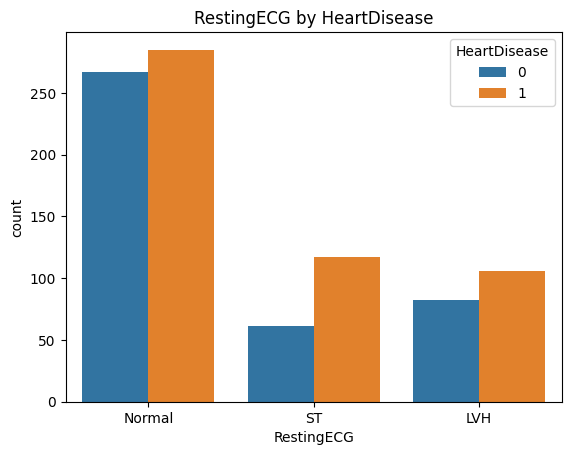

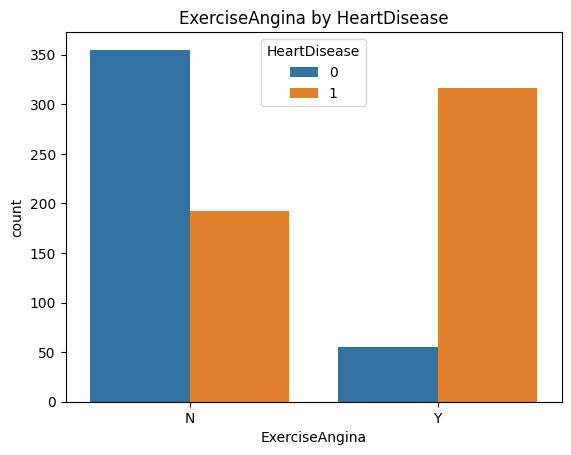

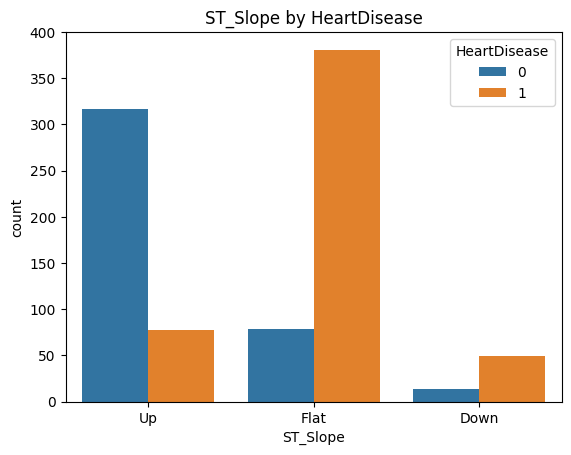

In [ ]:
# Boxplots of numerical features vs target
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for i in numerical_features:
    sns.boxplot(x='HeartDisease', y=i, data=dataset)
    plt.title(f'{i} by HeartDisease')
    plt.show()

# Countplots for categorical features vs target
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for i in categorical_features:
    sns.countplot(x=i, hue='HeartDisease', data=dataset)
    plt.title(f'{i} by HeartDisease')
    plt.show()

Summary:

According to above figures, all features are correlative with target value.

Next step:

Implement the preprocessing

## Preprocessing

- One-hot Encoding for categorical variables
- Dataset splitting
- Standardization for numerical variables.

In [ ]:
# One-hot encode
dataset_encoded = pd.get_dummies(dataset, drop_first=True)
dataset_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_M              918 non-null    bool   
 8   ChestPainType_ATA  918 non-null    bool   
 9   ChestPainType_NAP  918 non-null    bool   
 10  ChestPainType_TA   918 non-null    bool   
 11  RestingECG_Normal  918 non-null    bool   
 12  RestingECG_ST      918 non-null    bool   
 13  ExerciseAngina_Y   918 non-null    bool   
 14  ST_Slope_Flat      918 non-null    bool   
 15  ST_Slope_Up        918 non-null    bool   
dtypes: bool(9), float64(1), in

Next step:

Split the dataset into three parts:

- Training set: 64%
- Validation set: 16%
- Testing set: 20%

In [ ]:
# Split features and target
X = dataset_encoded.drop('HeartDisease', axis=1)
y = dataset_encoded['HeartDisease']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=936)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=936)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Testing shape:", X_test.shape)

Training shape: (587, 15)
Validation shape: (147, 15)
Testing shape: (184, 15)


Next step:

We need to standardize numerical features because logistic regression works better when features are on a similar scale. Normalization ensures each feature's effect is in the same level.

About fitting the transform scalar, we can only fit it based on training data set and use the same scalar for validation set and testing set. We can not get any information from test data set.

In [ ]:
scalar = StandardScaler()
X_train[numerical_features] = scalar.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scalar.transform(X_val[numerical_features])
X_test[numerical_features] = scalar.transform(X_test[numerical_features])
X_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
822,0.441510,-1.493950,0.358792,0,0.637325,-0.267071,True,False,True,False,False,False,True,True,False
157,-0.498255,0.366470,-0.138166,0,-0.274212,-0.847346,True,False,False,False,True,False,False,False,True
630,1.798949,-1.121866,-0.463448,0,-0.464115,0.700053,False,False,False,False,True,False,False,True,False
326,-0.915929,-1.228176,-1.809753,0,0.029634,-0.944059,True,False,True,False,True,False,False,False,True
461,0.963602,0.153850,-1.809753,0,-2.021325,-0.847346,True,False,False,False,True,False,True,True,False


Summary:

Now, the data is ready for modeling

## Model and Evaluation

- Plain logistic regression
- Logistic regression with polynomial feature transformation
- Logistic regression with Spline feature transformation

### Plain logistic regression

Train the logistic regression model without doing any other things.

In [ ]:
model_plain = LogisticRegression(max_iter=2000)
model_plain.fit(X_train, y_train)

# Get the accuracy on training set
train_score = model_plain.score(X_train, y_train)
print("Training accuracy:", round(train_score, 3))

# Get the accuracy on test set
test_score = model_plain.score(X_test, y_test)
print("Testing accuracy:", round(test_score, 3))

Training accuracy: 0.865
Testing accuracy: 0.859


Summary:

The performance of this plain model is good. There is not big gap between training accuracy and testing accuracy.

### Logistic Regression with Feature Tranformation (Polynomial)

The plain logistic regression can only capture linear relationship. Thus, we transform features to polynomial to fit non-linear relationship.

In [ ]:
# Create polynomial features (degree = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

# Train logistic regression
model_poly = LogisticRegression(max_iter=2000)
model_poly.fit(X_train_poly, y_train)

train_scores_poly = model_poly.score(X_train_poly, y_train)
val_score_poly = model_poly.score(X_val_poly, y_val)
test_score_poly = model_poly.score(X_test_poly, y_test)
print("Training accuracy (poly):", round(train_scores_poly, 3))
print("Validation accuracy (poly):", round(val_score_poly, 3))

Training accuracy (poly): 0.908
Validation accuracy (poly): 0.85


Summary:

We can see that, the polynomial model is not better than plain model. Seems like we don't need high degree features to fit this dataset.

Next step:

After polinomial transformation, the new features might have different scale compare with original features. So just in case, do standardization again.

In [ ]:
# Do standardization again after polynomial transformation
scalar = StandardScaler()
X_train_poly = scalar.fit_transform(X_train_poly)
X_val_poly = scalar.transform(X_val_poly)
X_test_poly = scalar.transform(X_test_poly)

model_poly_2 = LogisticRegression(max_iter=2000)
model_poly_2.fit(X_train_poly, y_train)

train_scores_poly2 = model_poly_2.score(X_train_poly, y_train)
val_score_poly2 = model_poly_2.score(X_val_poly, y_val)
test_score_poly2 = model_poly_2.score(X_test_poly, y_test)
print("Training accuracy (poly):", round(train_scores_poly2, 3))
print("Validation accuracy (poly):", round(val_score_poly2, 3))
print("Testing accuracy (poly):", round(test_score_poly2, 3))

Training accuracy (poly): 0.928
Validation accuracy (poly): 0.837
Testing accuracy (poly): 0.842


Summary:

From above result, we don't have obvious improvement.

Next step:

There is two hyperparameters in this training process: max_iter and degree. We will focus on degree and use validation data set to choose a better degree.

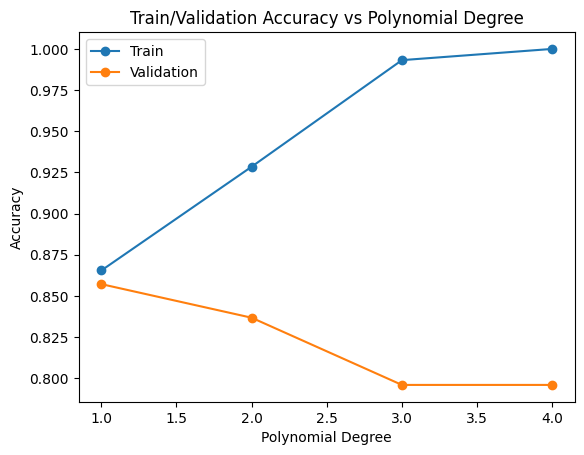

In [ ]:
degrees = [1, 2, 3, 4]
train_scores = []
val_scores = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_val_poly = scaler.transform(X_val_poly)
    X_test_poly = scaler.transform(X_test_poly)

    model_temp = LogisticRegression(max_iter=2000)
    model_temp.fit(X_train_poly, y_train)

    train_score = model_temp.score(X_train_poly, y_train)
    val_score = model_temp.score(X_val_poly, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

# Plot training set accuracy and validation set accuracy vs polynomial degree
plt.plot(degrees, train_scores, marker='o', label='Train')
plt.plot(degrees, val_scores, marker='o', label='Validation')
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy vs Polynomial Degree')
plt.legend()
plt.show()

Summary:

We can see that from degree = 1, the model starts overfitting. It might mean this polynomial model is too complicated for this dataset. Linear model is already enough for this dataset.

### Logistic Regression with Spline Feature Transformation

Although this dataset doesn't need complicated model, we still want to try Spline feature transformation. We will use pipeline and cross validation to make the model training easier and tune hyperparameters. We will focus on Spline knots amount and regularization weight.

In [ ]:
# Put all steps in a pipeline
pipeline = Pipeline([
    ('spline', SplineTransformer(degree=2)),
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=936, max_iter=3000))
])

# Put in parameters to test
param_grid = [
    {
        # L1 regularization
        'spline__n_knots': [3, 4, 5, 6, 7],
        'logistic__C': [0.01, 0.1, 1, 10, 100],
        'logistic__penalty': ['l1'],
        'logistic__solver': ['liblinear']
    },
    {
        # L2 regularization
        'spline__n_knots': [3, 4, 5, 6, 7, 8],
        'logistic__C': [0.01, 0.1, 1, 10, 100],
        'logistic__penalty': ['l2'],
        'logistic__solver': ['lbfgs']
    }
]

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Fit grid search
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

Best parameters: {'logistic__C': 0.01, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'spline__n_knots': 3}
Best CV score: 0.867


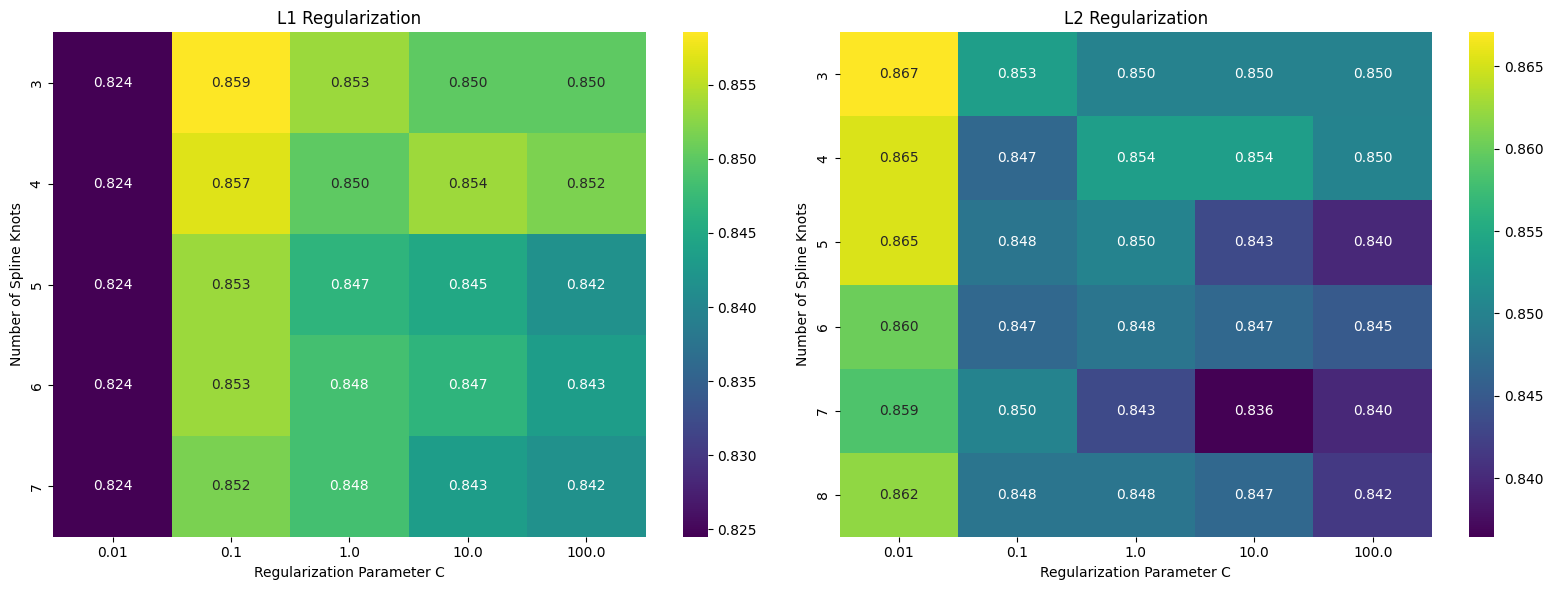

In [ ]:
# Analyze results
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot heatmap for C vs n_knots (separate for L1 and L2)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, penalty in enumerate(['l1', 'l2']):
    penalty_results = results_df[results_df['param_logistic__penalty'] == penalty]
    if not penalty_results.empty:
        pivot_table = penalty_results.pivot_table(
            values='mean_test_score',
            index='param_spline__n_knots',
            columns='param_logistic__C',
            aggfunc='mean'
        )

        sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f', ax=axes[i])
        axes[i].set_title(f'{penalty.upper()} Regularization')
        axes[i].set_xlabel('Regularization Parameter C')
        axes[i].set_ylabel('Number of Spline Knots')

plt.tight_layout()
plt.show()

Summary:

We can see that, 3 knots is the best choice, which means the dataset needs a simple model. L2 regularization obviously mitigate the overfitting. Regrading to L1 regularization, when we make it too strong, it reduces to many features to 0, makes the model underfitting, decreases the accuracy.

Next step:

Use the optimal hyperparameter to do evaluation on test data set.

In [ ]:
spline = SplineTransformer(degree=2, n_knots=3)
X_train_spline = spline.fit_transform(X_train)
X_val_spline = spline.transform(X_val)
X_test_spline = spline.transform(X_test)

# Train logistic regression
model_spline = LogisticRegression(max_iter=3000, C=0.01, penalty='l2')
model_spline.fit(X_train_spline, y_train)

test_score_spline = model_spline.score(X_test_spline, y_test)
print("Testing accuracy (spline):", round(test_score_spline, 3))

Testing accuracy (spline): 0.842


## Final Evaluation

Test accuracy:

- Plain logistic regression: 0.859
- Polynomial logistic regression: 0.842
- Spline logistic regression: 0.842

We are going to do some evaluation for plain logistic regression.

Confusion Matrix:
[[65 10]
 [16 93]]

AUC Score: 0.9357798165137615


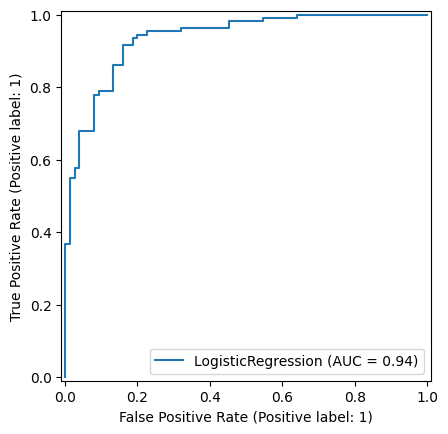

In [ ]:
y_pred = model_plain.predict(X_test)
y_proba = model_plain.predict_proba(X_test)[:, 1]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("\nAUC Score:", roc_auc)

# ROC
RocCurveDisplay.from_estimator(model_plain, X_test, y_test)
plt.show()

Summary:

The AUC Score is good which mean the model will not do strong bias prediction.

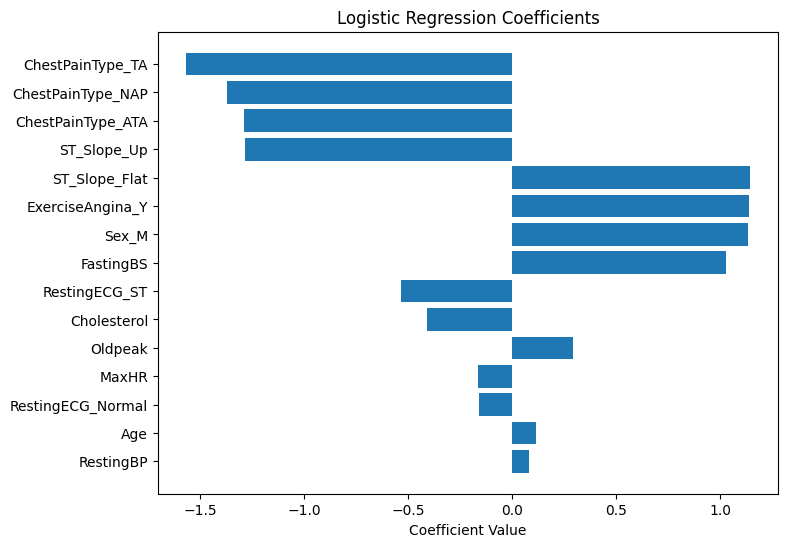

In [ ]:
# Get coefficients
coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_plain.coef_[0]
})

# Sort by significance
coef = coef.reindex(coef.Coefficient.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8, 6))
plt.barh(coef['Feature'], coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

Summary:

According to above figure, whether have Typical Angina Chest Pain is the most significant factor of heart disease.

## Conclusion

Regarding to this dataset. Plain logistic regression has the best performance. In my opinion, there are two possible reasons. First, the relationship between features and target value is linear, so that it doesn't need complicated model. Second, the data size is too small.

**Work in the future:**

- Do more feature selections
- Try more models
- Find better datasets